# Surface profile

In this notebook, we process the surface profile data obtained from the confocal distance measuring tool. NOTE: this data is not thickness.

In [13]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

## 1 Load data

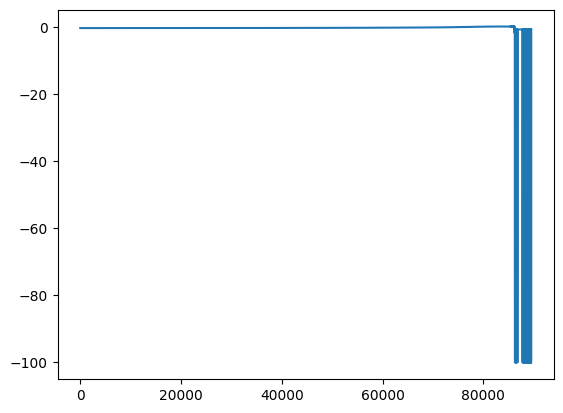

In [319]:
folder = r"F:\Zhengyang\04042024\Thin_film\Surface_profile"
filename = "petridish-rubber"
raw = pd.read_csv(os.path.join(folder, filename+".csv"), usecols=[1], skiprows=12)
plt.plot(raw)

## 2 Trim the last part

In the current method, I manually move the tool horizontally to achieve a scan. At the end of the scan, there is a delay between I stop moving the tool and I stop recording the signal. As a result, there is always a plateau at the end of each scan data, which should be manually removed before further processing.

(80000.0, 90000.0)

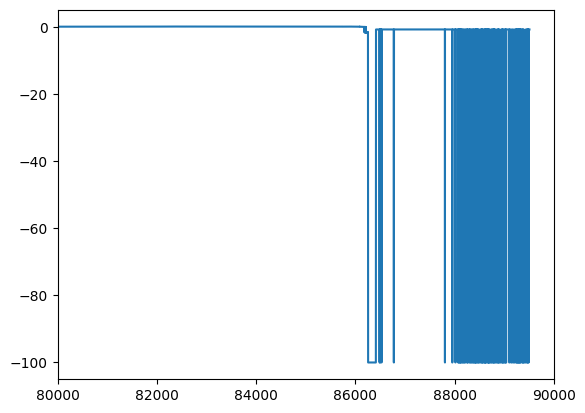

In [320]:
plt.plot(raw)
plt.xlim([80000,90000])

From the above view we know that the plateau starts at around 112,500. So we slice the raw data up to 112,500.

In [321]:
raw_slice = raw[:84000]

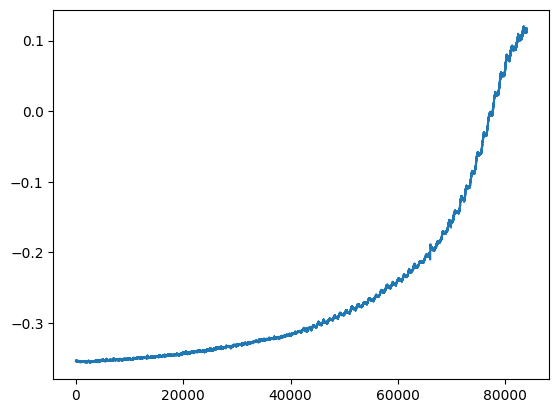

In [322]:
plt.plot(raw_slice)

## 3 Convert time series to surface profile

The data recorded are height vs. time. Since I manually move the tool to scan the samples over time, I'm able to convert the time series to height vs. x given recording frequency and moving speed. Manual moving is not accurate and all the results present here are only preliminary. 

Assume that each second, I move the measurement tool 0.005'' ($v \approx 0.125$ mm). The data were recorded at $f=1000$ Hz, meaning that 1000 points are roughly for 0.125 mm. Then I can use the following function to convert the data to height vs. x. Furthermore, the function will condense the number of data points, so that each second only contributes one data point. 

In [323]:
def condense_profile(raw, record_frequency, moving_speed):
    """
    Args:
    raw -- raw profile from the measuring tool, a 1-D array of height;
    record_frequency -- recording frequency of the tool, typically 1000 Hz;
    moving_speed -- speed of scan, I start with manual scan at roughly 0.125 mm/s, a motorized scanner is planned.
    Returns:
    x -- horizontal coordinates;
    height -- condensed surface profile data.
    """
    raw = np.array(raw)
    raw_slice = raw[:raw.shape[0]//record_frequency*record_frequency]
    raw_slice = raw_slice.reshape((raw_slice.shape[0]//record_frequency, record_frequency))
    height = raw_slice.mean(axis=1)
    x = np.arange(len(height)) * moving_speed
    return x, height

In [324]:
record_frequency = 1000
moving_speed = 0.125
xpos, height = condense_profile(raw_slice, record_frequency, moving_speed)

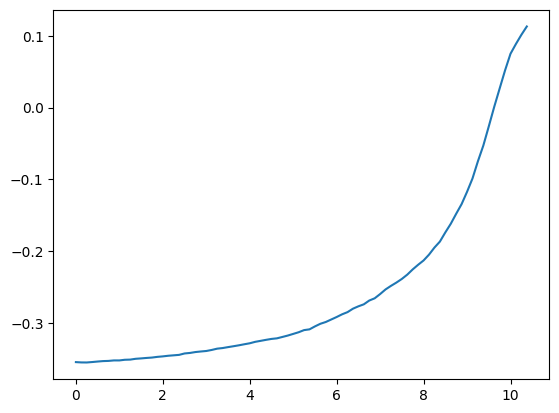

In [325]:
plt.plot(xpos, height)

## 4 Post processing

The starting points of this curve are arbitrary, both in $x$ and in height. $x=0$ is the point I choose to start the scan (see the following picture for a typical scan process). So we flip the surface profile horizontally, to use the meniscus near the solid as the starting point $x=0$ of the surface profile. To make results more consistent, we also define $y=0$ at the lowest point of the curve. The starting point is chosen to be the point where $y = 0.3$ mm. 

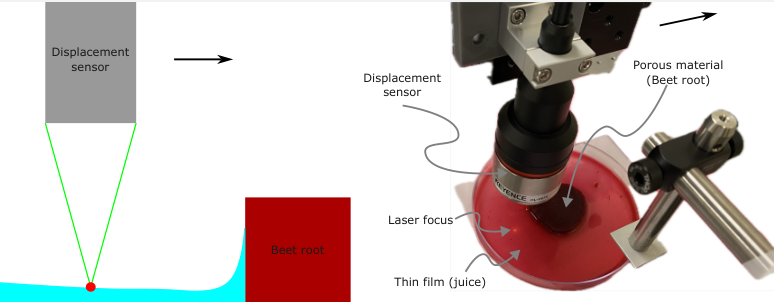

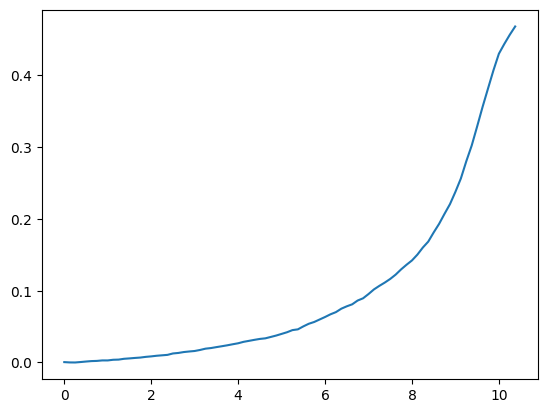

In [326]:
# define y=0 as the lowest point in the surface profile curve
height = height - height.min()
plt.plot(xpos, height)

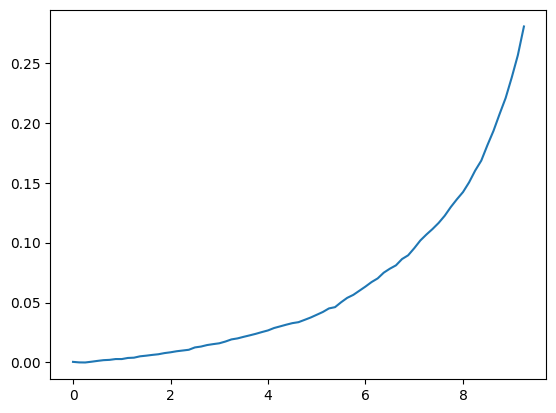

In [327]:
# take only the part where height<0.3
h = height[height<=0.3]
x = xpos[height<=0.3]
plt.plot(x, h)

(0.0, 0.3)

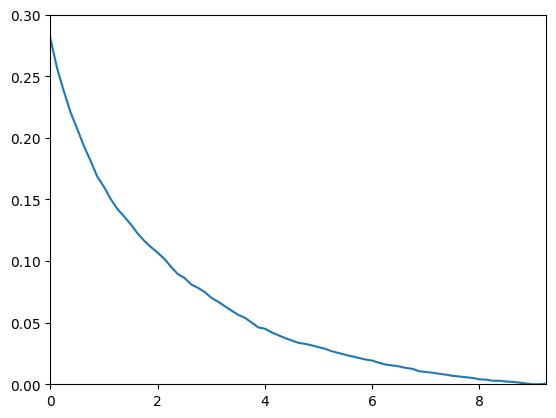

In [328]:
# flip horizontally
hflip = np.flip(h)
plt.plot(x, hflip)
plt.xlim([0, x.max()])
plt.ylim([0, 0.3])

## 5 Save processed surface profile

The resulting surface profiles have much less data points, but retain the essential surface shape (x, h). This reduced profile data will be saved in .csv files, which contains $x$ and $h$.

In [329]:
profile = pd.DataFrame({"x": x, "h": hflip})

In [330]:
profile.to_csv(os.path.join(folder, filename+"_proc.csv"), index=False)